**Parameters**

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

import pydicom

from os import listdir

from skimage.transform import resize
from imgaug import augmenters as iaa

from sklearn.model_selection import train_test_split

from keras.applications import ResNet50, VGG16
from keras.applications.resnet50 import preprocess_input as preprocess_resnet_50
from keras.applications.vgg16 import preprocess_input as preprocess_vgg_16

from keras.utils import Sequence

listdir("../input/rsna-intracranial-hemorrhage-detection/")

Using TensorFlow backend.


['stage_1_test_images',
 'stage_1_train.csv',
 'stage_1_sample_submission.csv',
 'stage_1_train_images']

In [2]:
INPUT_PATH = "../input/rsna-intracranial-hemorrhage-detection/"

In [3]:
#Exploratory analysis
##Sample Submission
submission = pd.read_csv(INPUT_PATH + "stage_1_sample_submission.csv")
submission.head(10)

,ID,Label
0,ID_28fbab7eb_epidural,0.5
1,ID_28fbab7eb_intraparenchymal,0.5
2,ID_28fbab7eb_intraventricular,0.5
3,ID_28fbab7eb_subarachnoid,0.5
4,ID_28fbab7eb_subdural,0.5
5,ID_28fbab7eb_any,0.5
6,ID_877923b8b_epidural,0.5
7,ID_877923b8b_intraparenchymal,0.5
8,ID_877923b8b_intraventricular,0.5
9,ID_877923b8b_subarachnoid,0.5


We can clearly see that we have to make several predictions for one image id:

    epidural
    subdural
    subarachnoid
    intraparenchymal
    intraventricular
    any - this one indicates that at least one subtype is present, hence it tells us if the patient has IH or not.

Evaluation metric

The weighted multilabel logarithmic loss is used to score our model performance. In the description it's given that the log loss is first taken for each subtype $s$ given an image id $n$:
ln,s=tn,s⋅ln(yn,s)+(1−tn,s)⋅ln(1−yn,s)

Then they seem to be added, whereas the any-subtype obtains a higher weight than the others:
ln=∑sws⋅ln,s

And finally this loss is averaged over all samples:
Loss=−1N⋅∑nln

Hopefully I got this right! ;-)

Interestingly the competition host has not provided the weights (or did they?). Hence this is going to be an LB probing hyperparameter to keep in mind.

In [4]:
#Target distribution

traindf = pd.read_csv(INPUT_PATH + "stage_1_train.csv")
traindf.head()

,ID,Label
0,ID_63eb1e259_epidural,0
1,ID_63eb1e259_intraparenchymal,0
2,ID_63eb1e259_intraventricular,0
3,ID_63eb1e259_subarachnoid,0
4,ID_63eb1e259_subdural,0


In [5]:
label = traindf.Label.values

traindf = traindf.ID.str.rsplit("_", n=1, expand=True)
traindf.loc[:, "label"] = label
traindf.head()

,0,1,label
0,ID_63eb1e259,epidural,0
1,ID_63eb1e259,intraparenchymal,0
2,ID_63eb1e259,intraventricular,0
3,ID_63eb1e259,subarachnoid,0
4,ID_63eb1e259,subdural,0


In [6]:
traindf = traindf.rename({0: "id", 1: "subtype"}, axis=1)
subtype_counts = traindf.groupby("subtype").label.value_counts().unstack()
subtype_counts = subtype_counts.loc[:, 1] / traindf.groupby("subtype").size() * 100

traindf.head()

,id,subtype,label
0,ID_63eb1e259,epidural,0
1,ID_63eb1e259,intraparenchymal,0
2,ID_63eb1e259,intraventricular,0
3,ID_63eb1e259,subarachnoid,0
4,ID_63eb1e259,subdural,0


In [7]:
testdf = submission.ID.str.rsplit("_", n=1, expand=True)
testdf = testdf.rename({0: "id", 1: "subtype"}, axis=1)
testdf.loc[:, "label"] = 0
testdf.head()

,id,subtype,label
0,ID_28fbab7eb,epidural,0
1,ID_28fbab7eb,intraparenchymal,0
2,ID_28fbab7eb,intraventricular,0
3,ID_28fbab7eb,subarachnoid,0
4,ID_28fbab7eb,subdural,0


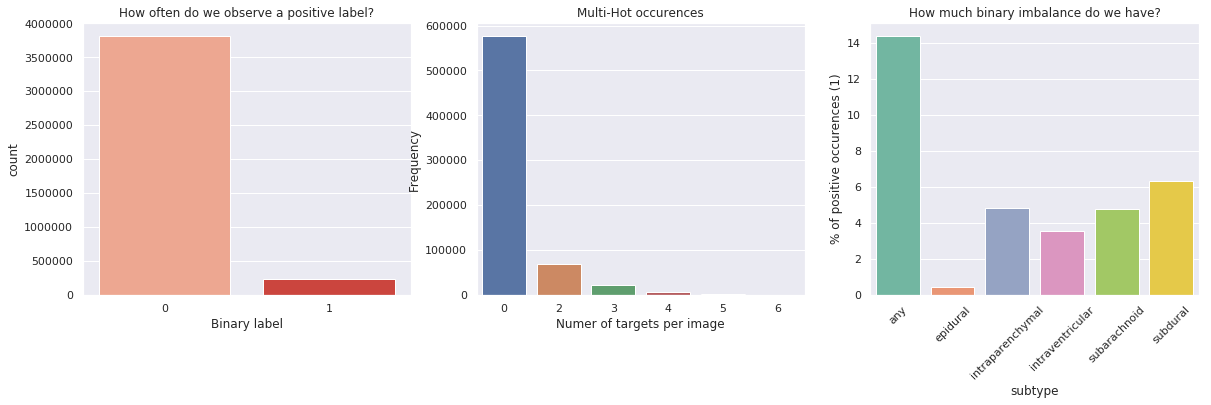

In [8]:
multi_target_count = traindf.groupby("id").label.sum()

fig, ax = plt.subplots(1,3,figsize=(20,5))

sns.countplot(traindf.label, ax=ax[0], palette="Reds")
ax[0].set_xlabel("Binary label")
ax[0].set_title("How often do we observe a positive label?");

sns.countplot(multi_target_count, ax=ax[1])
ax[1].set_xlabel("Numer of targets per image")
ax[1].set_ylabel("Frequency")
ax[1].set_title("Multi-Hot occurences")

sns.barplot(x=subtype_counts.index, y=subtype_counts.values, ax=ax[2], palette="Set2")
plt.xticks(rotation=45); 
ax[2].set_title("How much binary imbalance do we have?")
ax[2].set_ylabel("% of positive occurences (1)");

In [9]:
#Number of samples
traindf.head()

,id,subtype,label
0,ID_63eb1e259,epidural,0
1,ID_63eb1e259,intraparenchymal,0
2,ID_63eb1e259,intraventricular,0
3,ID_63eb1e259,subarachnoid,0
4,ID_63eb1e259,subdural,0


In [10]:
traindf.id.nunique()

674258

In [11]:
train_dir = INPUT_PATH + "stage_1_train_images/"
train_files = listdir(train_dir)

In [12]:
train_size = len(train_files)
train_size

674258

In [13]:
test_dir = INPUT_PATH + "stage_1_test_images/"
test_files = listdir(test_dir)
test_size = len(test_files)
test_size

78545

In [14]:
train_size/test_size

8.58435291870902

In [15]:
#Preprocessing dicom files

train_files[0:10]

['ID_ff816e9b6.dcm',
 'ID_282a7f3cd.dcm',
 'ID_f1c65b76e.dcm',
 'ID_3b59681d3.dcm',
 'ID_f506d79aa.dcm',
 'ID_04e5d961f.dcm',
 'ID_c6d3185e9.dcm',
 'ID_e3fe191f5.dcm',
 'ID_b046eb1fa.dcm',
 'ID_5f3c08ac0.dcm']

In [16]:
subtypes = traindf.subtype.unique()
subtypes

array(['epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid',
       'subdural', 'any'], dtype=object)

In [17]:
#What is given by a dicom file?
dataset = pydicom.dcmread(train_dir + "ID_c5c23af94.dcm")
print(dataset)

(0008, 0018) SOP Instance UID                    UI: ID_c5c23af94
(0008, 0060) Modality                            CS: 'CT'
(0010, 0020) Patient ID                          LO: 'ID_9630cc49'
(0020, 000d) Study Instance UID                  UI: ID_c5409f3ace
(0020, 000e) Series Instance UID                 UI: ID_5db30227b2
(0020, 0010) Study ID                            SH: ''
(0020, 0032) Image Position (Patient)            DS: ['-125.000', '-118.882', '33.678']
(0020, 0037) Image Orientation (Patient)         DS: ['1.000000', '0.000000', '0.000000', '0.000000', '0.951057', '-0.309017']
(0028, 0002) Samples per Pixel                   US: 1
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROME2'
(0028, 0010) Rows                                US: 512
(0028, 0011) Columns                             US: 512
(0028, 0030) Pixel Spacing                       DS: ['0.488281', '0.488281']
(0028, 0100) Bits Allocated                      US: 16
(0028, 0101) Bits Stored          

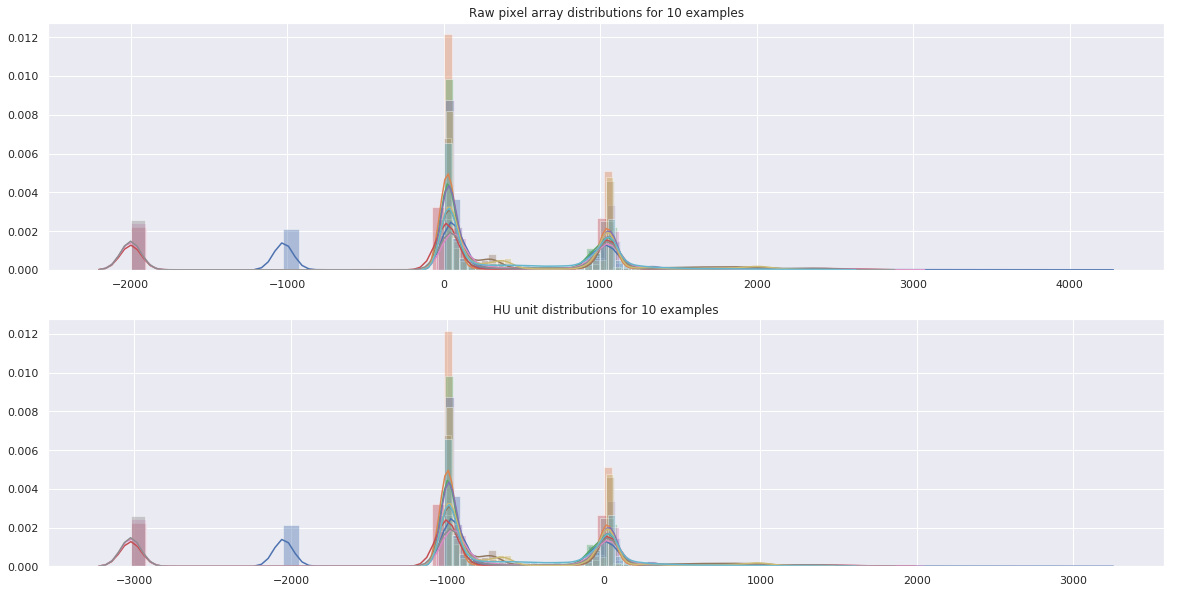

In [18]:
fig, ax = plt.subplots(2,1,figsize=(20,10))
for file in train_files[0:10]:
    dataset = pydicom.dcmread(train_dir + file)
    image = dataset.pixel_array.flatten()
    rescaled_image = image * dataset.RescaleSlope + dataset.RescaleIntercept
    sns.distplot(image.flatten(), ax=ax[0]);
    sns.distplot(rescaled_image.flatten(), ax=ax[1])
ax[0].set_title("Raw pixel array distributions for 10 examples")
ax[1].set_title("HU unit distributions for 10 examples");

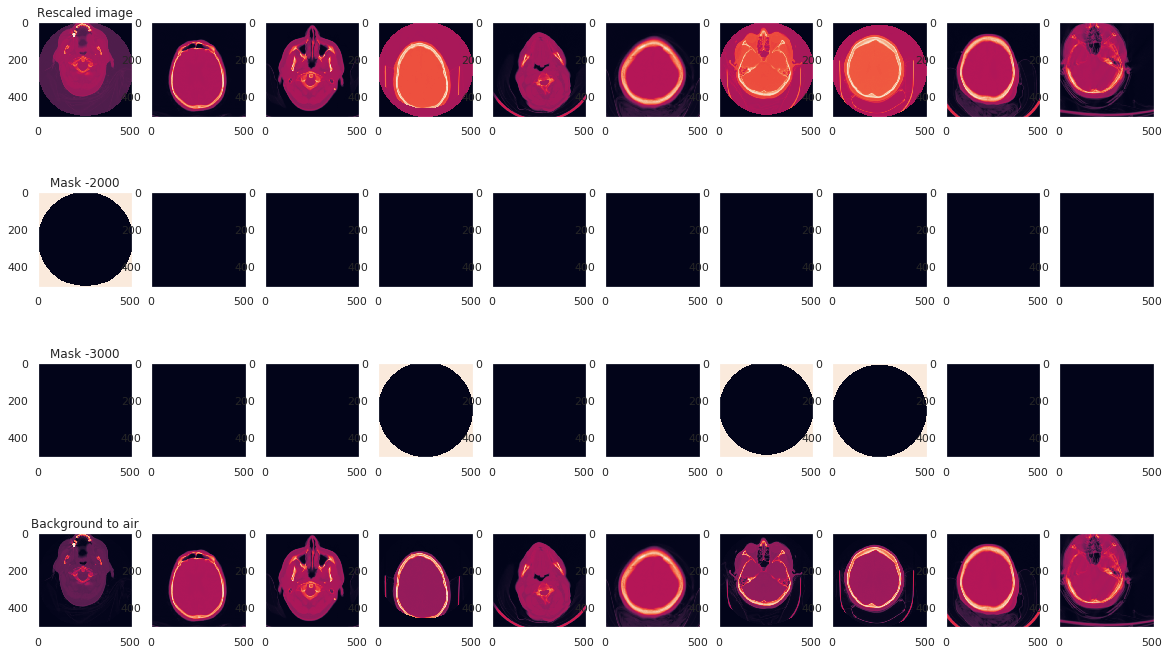

In [19]:
fig, ax = plt.subplots(4,10,figsize=(20,12))

for n in range(10):
    dataset = pydicom.dcmread(train_dir + train_files[n])
    image = dataset.pixel_array
    rescaled_image = image * dataset.RescaleSlope + dataset.RescaleIntercept
    mask2000 = np.where((rescaled_image <= -1500) & (rescaled_image > -2500), 1, 0)
    mask3000 = np.where(rescaled_image <= -2500, 1, 0)
    ax[0,n].imshow(rescaled_image)
    rescaled_image[rescaled_image < -1024] = -1024
    ax[1,n].imshow(mask2000)
    ax[2,n].imshow(mask3000)
    ax[3,n].imshow(rescaled_image)
    ax[0,n].grid(False)
    ax[1,n].grid(False)
    ax[2,n].grid(False)
    ax[3,n].grid(False)
ax[0,0].set_title("Rescaled image")
ax[1,0].set_title("Mask -2000")
ax[2,0].set_title("Mask -3000");
ax[3,0].set_title("Background to air");

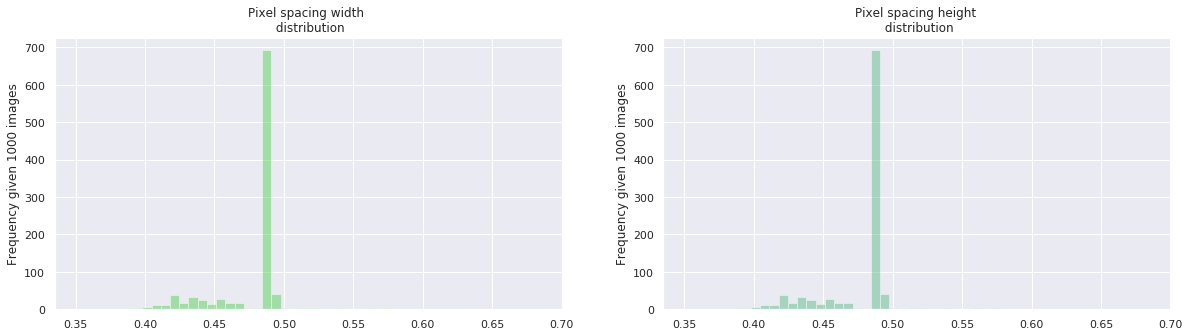

In [20]:
pixelspacing_w = []
pixelspacing_h = []
spacing_filenames = []
for file in train_files[0:1000]:
    dataset = pydicom.dcmread(train_dir + file)
    spacing = dataset.PixelSpacing
    pixelspacing_w.append(spacing[0])
    pixelspacing_h.append(spacing[1])
    spacing_filenames.append(file)

fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.distplot(pixelspacing_w, ax=ax[0], color="Limegreen", kde=False)
ax[0].set_title("Pixel spacing width \n distribution")
ax[0].set_ylabel("Frequency given 1000 images")
sns.distplot(pixelspacing_h, ax=ax[1], color="Mediumseagreen", kde=False)
ax[1].set_title("Pixel spacing height \n distribution");
ax[1].set_ylabel("Frequency given 1000 images");

In [21]:
min_file = spacing_filenames[np.argmin(pixelspacing_w)]
max_file = spacing_filenames[np.argmax(pixelspacing_w)]

def rescale_pixelarray(dataset):
    image = dataset.pixel_array
    rescaled_image = image * dataset.RescaleSlope + dataset.RescaleIntercept
    rescaled_image[rescaled_image < -1024] = -1024
    return rescaled_image

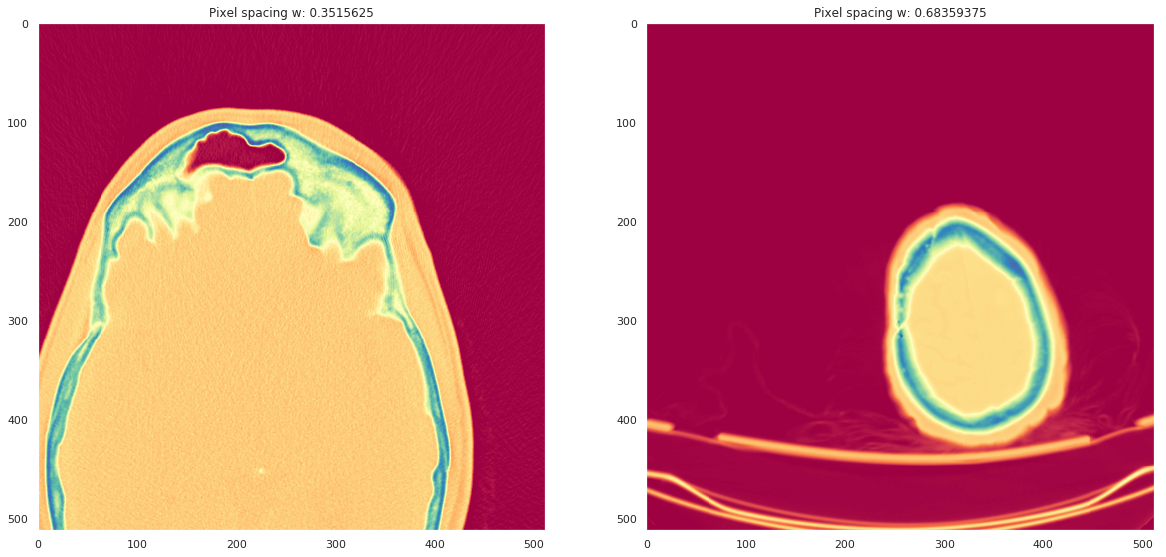

In [22]:
fig, ax = plt.subplots(1,2,figsize=(20,10))

dataset_min = pydicom.dcmread(train_dir + min_file)
image_min = rescale_pixelarray(dataset_min)

dataset_max = pydicom.dcmread(train_dir + max_file)
image_max = rescale_pixelarray(dataset_max)

ax[0].imshow(image_min, cmap="Spectral")
ax[0].set_title("Pixel spacing w: " + str(np.min(pixelspacing_w)))
ax[1].imshow(image_max, cmap="Spectral");
ax[1].set_title("Pixel spacing w: " + str(np.max(pixelspacing_w)))
ax[0].grid(False)
ax[1].grid(False)

In [23]:
np.min(pixelspacing_w) * 512

180.0

In [24]:
np.max(pixelspacing_w) * 512

350.0

In [25]:
#Doctors Windows
def get_window_value(feature):
    if type(feature) == pydicom.multival.MultiValue:
        return np.int(feature[0])
    else:
        return np.int(feature)

window_widths = []
window_levels = []
spacing_filenames = []
for file in train_files[0:1000]:
    dataset = pydicom.dcmread(train_dir + file)
    win_width = get_window_value(dataset.WindowWidth)
    win_center = get_window_value(dataset.WindowCenter)
    window_widths.append(win_width)
    window_levels.append(win_center)
    spacing_filenames.append(file)

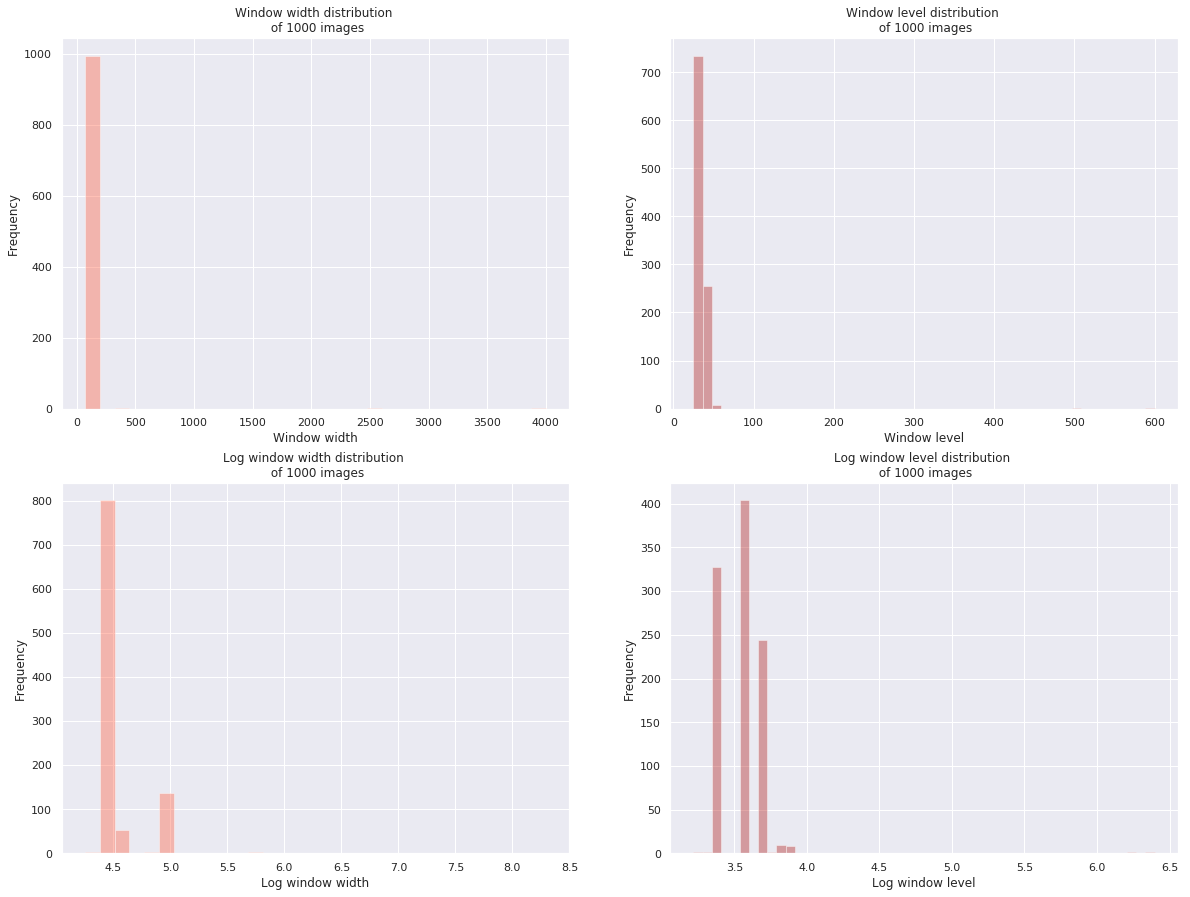

In [26]:
fig, ax = plt.subplots(2,2,figsize=(20,15))

sns.distplot(window_widths, kde=False, ax=ax[0,0], color="Tomato")
ax[0,0].set_title("Window width distribution \n of 1000 images")
ax[0,0].set_xlabel("Window width")
ax[0,0].set_ylabel("Frequency")

sns.distplot(window_levels, kde=False, ax=ax[0,1], color="Firebrick")
ax[0,1].set_title("Window level distribution \n of 1000 images")
ax[0,1].set_xlabel("Window level")
ax[0,1].set_ylabel("Frequency")

sns.distplot(np.log(window_widths), kde=False, ax=ax[1,0], color="Tomato")
ax[1,0].set_title("Log window width distribution \n of 1000 images")
ax[1,0].set_xlabel("Log window width")
ax[1,0].set_ylabel("Frequency")

sns.distplot(np.log(window_levels), kde=False, ax=ax[1,1], color="Firebrick")
ax[1,1].set_title("Log window level distribution \n of 1000 images")
ax[1,1].set_xlabel("Log window level")
ax[1,1].set_ylabel("Frequency");

In [27]:
#Custom Window
doc_windows = pd.DataFrame(index=spacing_filenames, columns=["win_width", "win_level"])
doc_windows["win_width"] = window_widths
doc_windows["win_level"] = window_levels
doc_windows.head(20)

,win_width,win_level
ID_ff816e9b6.dcm,150,40
ID_282a7f3cd.dcm,80,36
ID_f1c65b76e.dcm,80,36
ID_3b59681d3.dcm,80,30
ID_f506d79aa.dcm,80,36
ID_04e5d961f.dcm,80,36
ID_c6d3185e9.dcm,80,30
ID_e3fe191f5.dcm,100,35
ID_b046eb1fa.dcm,80,36
ID_5f3c08ac0.dcm,80,40


In [28]:
doc_windows[doc_windows.win_width==doc_windows.win_width.median()]

,win_width,win_level
ID_282a7f3cd.dcm,80,36
ID_f1c65b76e.dcm,80,36
ID_3b59681d3.dcm,80,30
ID_f506d79aa.dcm,80,36
ID_04e5d961f.dcm,80,36
...,...,...
ID_6d92e8ff0.dcm,80,30
ID_1c73ce296.dcm,80,36
ID_4f28c3832.dcm,80,40
ID_116de79da.dcm,80,30


In [29]:
doc_windows.describe()

,win_width,win_level
count,1000.000000,1000.000000
mean,96.955000,36.180000
std,147.326536,23.509664
min,70.000000,25.000000
25%,80.000000,30.000000
50%,80.000000,36.000000
75%,80.000000,40.000000
max,4000.000000,600.000000


In [30]:
np.quantile(window_widths, 0.95)

150.0

In [31]:
np.quantile(window_levels, 0.95)

40.0

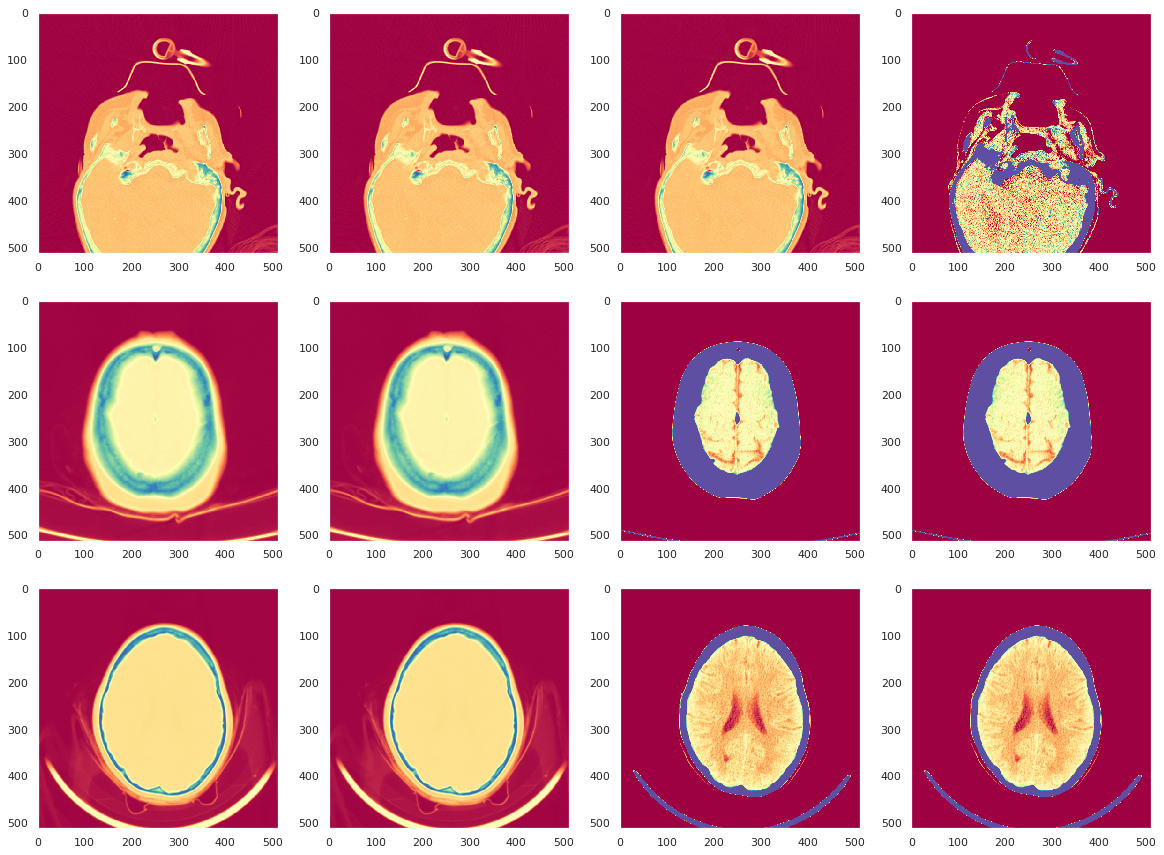

In [32]:
def set_manual_window(hu_image, custom_center, custom_width):
    min_value = custom_center - (custom_width/2)
    max_value = custom_center + (custom_width/2)
    hu_image[hu_image < min_value] = min_value
    hu_image[hu_image > max_value] = max_value
    return hu_image

fig, ax = plt.subplots(3,4,figsize=(20,15))

docs_dict = {"ID_352b300f9.dcm": {"width": 4000, "level": 600},
             "ID_7e7d7633a.dcm": {"width": 70, "level": 30},
             "ID_87e8b2528.dcm": {"width": 80, "level": 40}}
n = 0
for file in ["ID_352b300f9.dcm", "ID_7e7d7633a.dcm", "ID_87e8b2528.dcm"]:
    dataset = pydicom.dcmread(train_dir + file)
    pixelarray = dataset.pixel_array
    ax[n,0].imshow(pixelarray, cmap="Spectral")
    ax[n,0].grid(False)
    rescaled_image = rescale_pixelarray(dataset)
    ax[n,1].imshow(rescaled_image, cmap="Spectral")
    ax[n,1].grid(False)
    
    org_windowed_image = set_manual_window(rescaled_image, docs_dict[file]["level"], docs_dict[file]["width"])
    ax[n,2].imshow(org_windowed_image, cmap="Spectral")
    ax[n,2].grid(False)
    
    new_windowed_image = set_manual_window(rescaled_image, 40, 150)
    ax[n,3].imshow(new_windowed_image, cmap="Spectral")
    ax[n,3].grid(False)
    
    n+=1

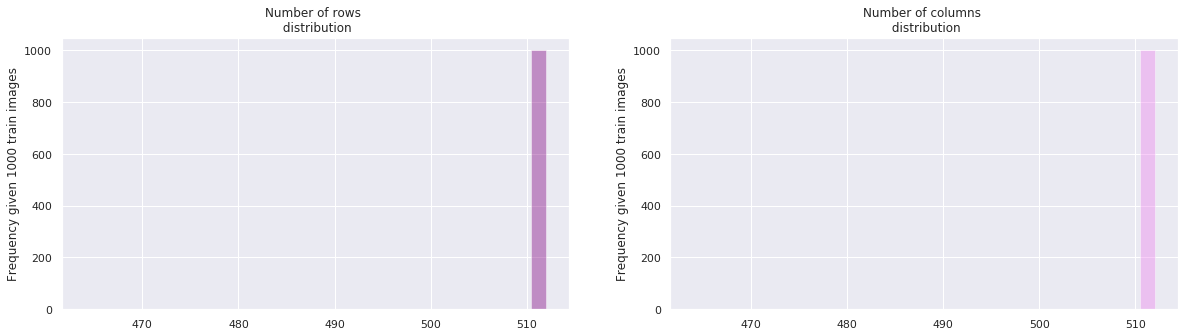

In [33]:
num_rows = []
num_cols = []
spacing_filenames = []
for file in train_files[0:1000]:
    dataset = pydicom.dcmread(train_dir + file)
    num_rows.append(dataset.Rows)
    num_cols.append(dataset.Columns)
    spacing_filenames.append(file)

fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.distplot(num_rows, ax=ax[0], color="Purple", kde=False)
ax[0].set_title("Number of rows \n distribution")
ax[0].set_ylabel("Frequency given 1000 train images")
sns.distplot(num_cols, ax=ax[1], color="Violet", kde=False)
ax[1].set_title("Number of columns \n distribution");
ax[1].set_ylabel("Frequency given 1000 train images");

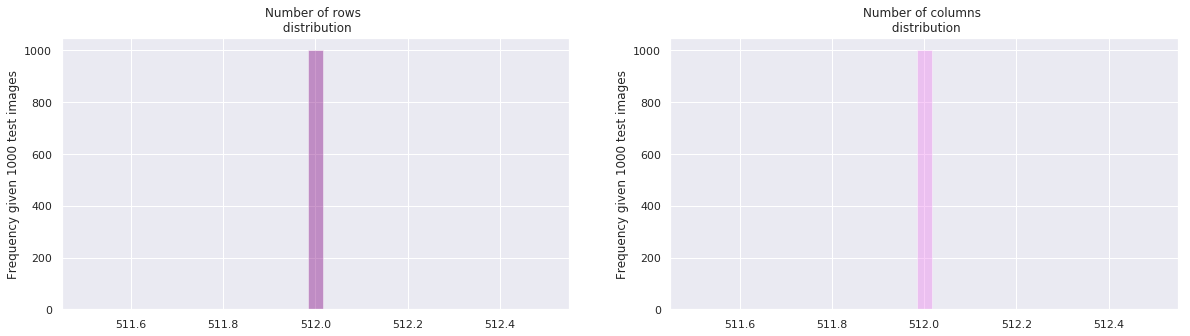

In [34]:
num_rows = []
num_cols = []
spacing_filenames = []
for file in test_files[0:1000]:
    dataset = pydicom.dcmread(test_dir + file)
    num_rows.append(dataset.Rows)
    num_cols.append(dataset.Columns)
    spacing_filenames.append(file)

fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.distplot(num_rows, ax=ax[0], color="Purple", kde=False)
ax[0].set_title("Number of rows \n distribution")
ax[0].set_ylabel("Frequency given 1000 test images")
sns.distplot(num_cols, ax=ax[1], color="Violet", kde=False)
ax[1].set_title("Number of columns \n distribution");
ax[1].set_ylabel("Frequency given 1000 test images");

In [35]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

import pydicom

from os import listdir

from skimage.transform import resize
from imgaug import augmenters as iaa

from sklearn.model_selection import train_test_split

from keras.applications import ResNet50, VGG16
from keras.applications.resnet50 import preprocess_input as preprocess_resnet_50
from keras.applications.vgg16 import preprocess_input as preprocess_vgg_16
from keras.layers import GlobalAveragePooling2D, Dense, Activation, concatenate, Dropout
from keras.initializers import glorot_normal, he_normal
from keras.regularizers import l2
from keras.models import Model, load_model
from keras.utils import Sequence
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.optimizers import Adam


from tensorflow.nn import sigmoid_cross_entropy_with_logits
import tensorflow as tf

listdir("../input/rsna-intracranial-hemorrhage-detection/stage_1_test_images")

['ID_cec48be98.dcm',
 'ID_24499006f.dcm',
 'ID_398dc0001.dcm',
 'ID_b6b34b14f.dcm',
 'ID_6cab4d011.dcm',
 'ID_c16f5348b.dcm',
 'ID_d435b1447.dcm',
 'ID_ffbe4d388.dcm',
 'ID_4c98e0dfe.dcm',
 'ID_7b41cd45f.dcm',
 'ID_09cb6d8b8.dcm',
 'ID_99e3d42b5.dcm',
 'ID_64afd8922.dcm',
 'ID_0c23ca286.dcm',
 'ID_534e5d927.dcm',
 'ID_ecb9df342.dcm',
 'ID_9ca9f35f8.dcm',
 'ID_389a5b708.dcm',
 'ID_d608c5457.dcm',
 'ID_66f1ebf37.dcm',
 'ID_3283b3264.dcm',
 'ID_a68c2b4ee.dcm',
 'ID_16ff8016a.dcm',
 'ID_52b5748cb.dcm',
 'ID_5bdd671fa.dcm',
 'ID_b2f95df5d.dcm',
 'ID_80e6cdf85.dcm',
 'ID_91865ab55.dcm',
 'ID_daede3816.dcm',
 'ID_757ec6d6c.dcm',
 'ID_6cc58d806.dcm',
 'ID_7033f4fa3.dcm',
 'ID_84f2632ef.dcm',
 'ID_b7e96a990.dcm',
 'ID_f99f1e84c.dcm',
 'ID_ce1bde569.dcm',
 'ID_bf8be2d9b.dcm',
 'ID_a0625d887.dcm',
 'ID_5797dd3d1.dcm',
 'ID_46d7d8b8e.dcm',
 'ID_3abe78ee9.dcm',
 'ID_c18fd40b7.dcm',
 'ID_42b0666ad.dcm',
 'ID_18b5f8c80.dcm',
 'ID_cae97b137.dcm',
 'ID_f9f8bba67.dcm',
 'ID_e04e40851.dcm',
 'ID_9727524f

In [36]:
MODELOUTPUT_PATH = ""
brute_force_model_input = "../input/rsna-intracranial-hemorrhage-detection/stage_1_train_images"
brute_force_losses_path = "../input/rsna-intracranial-hemorrhage-detection/stage_1_train.csv"

def rescale_pixelarray(dataset):
    image = dataset.pixel_array
    rescaled_image = image * dataset.RescaleSlope + dataset.RescaleIntercept
    rescaled_image[rescaled_image < -1024] = -1024
    return rescaled_image

def set_manual_window(hu_image, custom_center, custom_width):
    min_value = custom_center - (custom_width/2)
    max_value = custom_center + (custom_width/2)
    hu_image[hu_image < min_value] = min_value
    hu_image[hu_image > max_value] = max_value
    return hu_image

class Preprocessor:    
    
    def __init__(self, path, backbone, ct_level, ct_width, augment=False):
        self.path = path
        self.backbone = backbone
        self.nn_input_shape = backbone["nn_input_shape"]
        self.ct_level = ct_level
        self.ct_width = ct_width
        self.augment = augment
        
    # 1. We need to load the dicom dataset
    def load_dicom_dataset(self, filename):
        dataset = pydicom.dcmread(self.path + filename)
        return dataset
    
    # 2. We need to rescale the pixelarray to Hounsfield units
    #    and we need to focus on our custom window:
    def get_hounsfield_window(self, dataset, level, width):
        try:
            hu_image = rescale_pixelarray(dataset)
            windowed_image = set_manual_window(hu_image, level, width)
        except ValueError:
            # set to minimum background value
            windowed_image = (level-width/2) * np.ones((self.nn_input_shape[0], self.nn_input_shape[1]))
        return windowed_image
        
    
    # 3. Resize the image to the input shape of our CNN
    def resize(self, image):
        image = resize(image, self.nn_input_shape)
        return image
    
    # 4. If we like to augment our image, let's do it:
    def augment_img(self, image):
        augment_img = iaa.Sequential([
            iaa.OneOf([
                iaa.Affine(rotate=(-180, 180)),
                iaa.Fliplr(0.5),
                iaa.Flipud(0.5),
                
            ])], random_order=True)
        
        image_aug = augment_img.augment_image(image)
        return image_aug
    
    def fill_channels(self, image):
        filled_image = np.stack((image,)*3, axis=-1)
        return filled_image
    
    def preprocess(self, identifier):
        filename = identifier +  ".dcm"
        dataset = self.load_dicom_dataset(filename)
        windowed_image = self.get_hounsfield_window(dataset, self.ct_level, self.ct_width)
        image = self.resize(windowed_image)
        if self.augment:
            image = self.augment_img(image)
        image = self.fill_channels(image)
        return image
    
    def normalize(self, image):
        image = (image - image.mean())/image.std()
        return image

In [37]:
class DataLoader(Sequence):
    
    def __init__(self, dataframe,
                 preprocessor,
                 batch_size,
                 shuffle,
                 num_classes=6,
                 steps=None):
        self.preprocessor = preprocessor
        self.data_ids = dataframe.index.values
        self.dataframe = dataframe
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.input_shape = self.preprocessor.backbone["nn_input_shape"]
        self.preprocess_fun = self.preprocessor.backbone["preprocess_fun"]
        self.num_classes = num_classes
        self.current_epoch=0
        self.steps=steps
        
    # defines the number of steps per epoch
    def __len__(self):
        if self.steps is None:
            return np.int(np.floor(len(self.data_ids) / np.float(self.batch_size)))
        else:
            return np.int(self.steps)
    
    # at the end of an epoch we may like to shuffle the data_ids:
    def on_epoch_end(self):
        if self.shuffle == True:
            np.random.RandomState(self.current_epoch).shuffle(self.data_ids)
            self.current_epoch += 1
    
    # should return a batch of images
    def __getitem__(self, step):
        # select the ids of the current batch
        current_ids = self.data_ids[step*self.batch_size:(step+1)*self.batch_size]
        X, y = self.__generate_batch(current_ids)
        return X, y
    
    # collect the preprocessed images and targets of one batch
    def __generate_batch(self, current_ids):
        X = np.empty((self.batch_size, *self.input_shape, 3))
        y = np.empty((self.batch_size, self.num_classes))
        for idx, ident in enumerate(current_ids):
            # Store sample
            image = self.preprocessor.preprocess(ident)
            X[idx] = self.preprocessor.normalize(image)
            # Store class
            y[idx] = self.__get_target(ident)
        return X, y
    
    # extract the targets of one image id:
    def __get_target(self, ident):
        targets = self.dataframe.loc[ident].values
        return targets

In [38]:
INPUT_PATH = "../input/rsna-intracranial-hemorrhage-detection/"
train_dir = INPUT_PATH + "stage_1_train_images/"
test_dir = INPUT_PATH + "stage_1_test_images/"

submission = pd.read_csv(INPUT_PATH + "stage_1_sample_submission.csv")
submission.head(7)

,ID,Label
0,ID_28fbab7eb_epidural,0.5
1,ID_28fbab7eb_intraparenchymal,0.5
2,ID_28fbab7eb_intraventricular,0.5
3,ID_28fbab7eb_subarachnoid,0.5
4,ID_28fbab7eb_subdural,0.5
5,ID_28fbab7eb_any,0.5
6,ID_877923b8b_epidural,0.5


In [39]:
traindf = pd.read_csv(INPUT_PATH + "stage_1_train.csv")
traindf.head()

,ID,Label
0,ID_63eb1e259_epidural,0
1,ID_63eb1e259_intraparenchymal,0
2,ID_63eb1e259_intraventricular,0
3,ID_63eb1e259_subarachnoid,0
4,ID_63eb1e259_subdural,0


In [40]:
label = traindf.Label.values
traindf = traindf.ID.str.rsplit("_", n=1, expand=True)
traindf.loc[:, "label"] = label
traindf = traindf.rename({0: "id", 1: "subtype"}, axis=1)
traindf.head()

,id,subtype,label
0,ID_63eb1e259,epidural,0
1,ID_63eb1e259,intraparenchymal,0
2,ID_63eb1e259,intraventricular,0
3,ID_63eb1e259,subarachnoid,0
4,ID_63eb1e259,subdural,0


In [41]:
testdf = submission.ID.str.rsplit("_", n=1, expand=True)
testdf = testdf.rename({0: "id", 1: "subtype"}, axis=1)
testdf.loc[:, "label"] = 0
testdf.head()

,id,subtype,label
0,ID_28fbab7eb,epidural,0
1,ID_28fbab7eb,intraparenchymal,0
2,ID_28fbab7eb,intraventricular,0
3,ID_28fbab7eb,subarachnoid,0
4,ID_28fbab7eb,subdural,0


In [42]:
traindf = pd.pivot_table(traindf, index="id", columns="subtype", values="label")
traindf.head()

subtype,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
id,,,,,,
ID_000039fa0,0,0,0,0,0,0
ID_00005679d,0,0,0,0,0,0
ID_00008ce3c,0,0,0,0,0,0
ID_0000950d7,0,0,0,0,0,0
ID_0000aee4b,0,0,0,0,0,0


In [43]:
testdf = pd.pivot_table(testdf, index="id", columns="subtype", values="label")
testdf.head(1)

subtype,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
id,,,,,,
ID_000012eaf,0,0,0,0,0,0


In [44]:
# Images Example
import glob, pylab, pandas as pd
import pydicom, numpy as np
from os import listdir
from os.path import isfile, join
import matplotlib.pylab as plt
import os
import seaborn as sns

from keras import layers
from keras.applications import DenseNet121
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam
from tqdm import tqdm

train_images_dir = '../input/rsna-intracranial-hemorrhage-detection/stage_1_train_images/'
train_images = [f for f in listdir(train_images_dir) if os.path.isfile(join(train_images_dir, f))]
test_images_dir = '../input/rsna-intracranial-hemorrhage-detection/stage_1_test_images/'
test_images = [f for f in listdir(test_images_dir) if os.path.isfile(join(test_images_dir, f))]
print('5 Training images', train_images[:5]) # Print the first 5

5 Training images ['ID_ff816e9b6.dcm', 'ID_282a7f3cd.dcm', 'ID_f1c65b76e.dcm', 'ID_3b59681d3.dcm', 'ID_f506d79aa.dcm']


In [45]:
print('Total File sizes')
for f in os.listdir('../input/rsna-intracranial-hemorrhage-detection'):
    if 'zip' not in f:
        print(f.ljust(30) + str(round(os.path.getsize('../input/rsna-intracranial-hemorrhage-detection/' + f) / 1000000, 2)) + 'MB')

Total File sizes
stage_1_test_images           2.82MB
stage_1_train.csv             107.21MB
stage_1_sample_submission.csv 13.43MB
stage_1_train_images          23.84MB


In [46]:
print('Number of train images:', len(train_images))
print('Number of test images:', len(test_images))

Number of train images: 674258
Number of test images: 78545


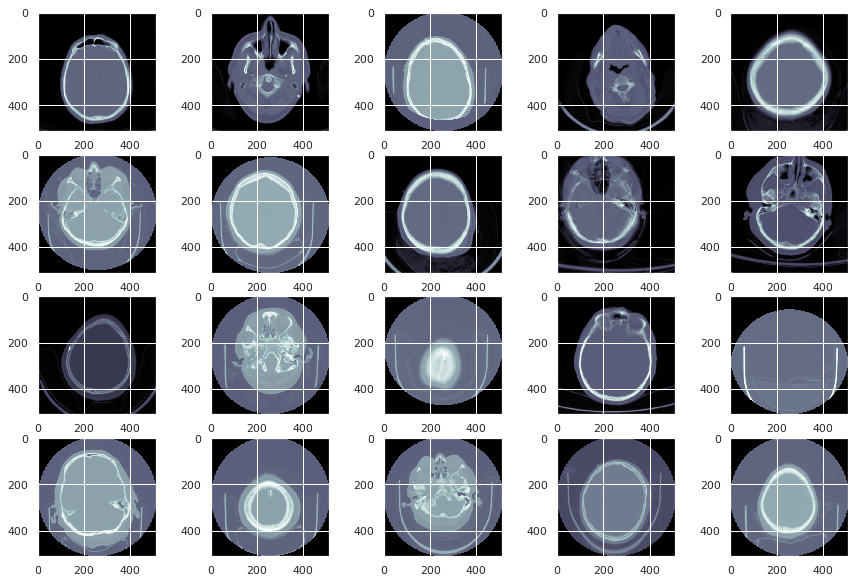

In [47]:
#Overview of DICOM files and medical images

fig=plt.figure(figsize=(15, 10))
columns = 5; rows = 4
for i in range(1, columns*rows +1):
    ds = pydicom.dcmread(train_images_dir + train_images[i])
    fig.add_subplot(rows, columns, i)
    plt.imshow(ds.pixel_array, cmap=plt.cm.bone)
    fig.add_subplot

In [48]:
print(ds) # this is file type of image

(0008, 0018) SOP Instance UID                    UI: ID_f95e7ca1c
(0008, 0060) Modality                            CS: 'CT'
(0010, 0020) Patient ID                          LO: 'ID_f90232f3'
(0020, 000d) Study Instance UID                  UI: ID_a3abf0d44d
(0020, 000e) Series Instance UID                 UI: ID_c268271666
(0020, 0010) Study ID                            SH: ''
(0020, 0032) Image Position (Patient)            DS: ['-125.000000', '-149.715240', '157.344299']
(0020, 0037) Image Orientation (Patient)         DS: ['1.000000', '0.000000', '0.000000', '0.000000', '0.994522', '0.104528']
(0028, 0002) Samples per Pixel                   US: 1
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROME2'
(0028, 0010) Rows                                US: 512
(0028, 0011) Columns                             US: 512
(0028, 0030) Pixel Spacing                       DS: ['0.488281', '0.488281']
(0028, 0100) Bits Allocated                      US: 16
(0028, 0101) Bits Stored 

In [49]:
im = ds.pixel_array
print(type(im))
print(im.dtype)
print(im.shape)

<class 'numpy.ndarray'>
int16
(512, 512)


In [50]:
train = pd.read_csv('../input/rsna-intracranial-hemorrhage-detection/stage_1_train.csv')

train.head(10)

,ID,Label
0,ID_63eb1e259_epidural,0
1,ID_63eb1e259_intraparenchymal,0
2,ID_63eb1e259_intraventricular,0
3,ID_63eb1e259_subarachnoid,0
4,ID_63eb1e259_subdural,0
5,ID_63eb1e259_any,0
6,ID_2669954a7_epidural,0
7,ID_2669954a7_intraparenchymal,0
8,ID_2669954a7_intraventricular,0
9,ID_2669954a7_subarachnoid,0


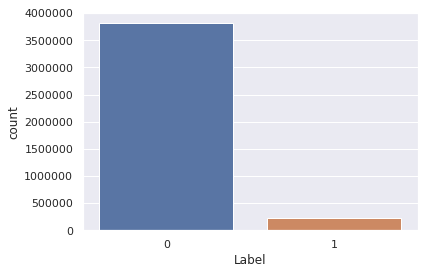

In [51]:
#DATA VISUALISATION
sns.countplot(train.Label)

In [52]:
train.Label.value_counts()

0    3814760
1     230812
Name: Label, dtype: int64

(-0.5, 511.5, 511.5, -0.5)

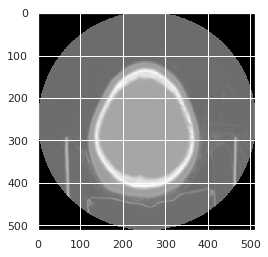

In [53]:
pylab.imshow(im, cmap=pylab.cm.gist_gray)
pylab.axis('on')

In [54]:
#Working newTable
train['Sub_type'] = train['ID'].str.split("_", n = 3, expand = True)[2]
train['PatientID'] = train['ID'].str.split("_", n = 3, expand = True)[1]

train.head()

,ID,Label,Sub_type,PatientID
0,ID_63eb1e259_epidural,0,epidural,63eb1e259
1,ID_63eb1e259_intraparenchymal,0,intraparenchymal,63eb1e259
2,ID_63eb1e259_intraventricular,0,intraventricular,63eb1e259
3,ID_63eb1e259_subarachnoid,0,subarachnoid,63eb1e259
4,ID_63eb1e259_subdural,0,subdural,63eb1e259


In [55]:
gbSub = train.groupby('Sub_type').sum()
gbSub

,Label
Sub_type,
any,97103
epidural,2761
intraparenchymal,32564
intraventricular,23766
subarachnoid,32122
subdural,42496


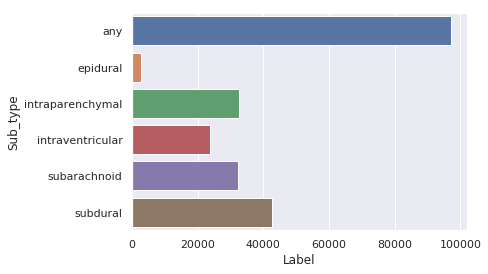

In [56]:
sns.barplot(y=gbSub.index, x=gbSub.Label, palette="deep")

Text(0.5, 1.0, 'Total Images by Subtype')

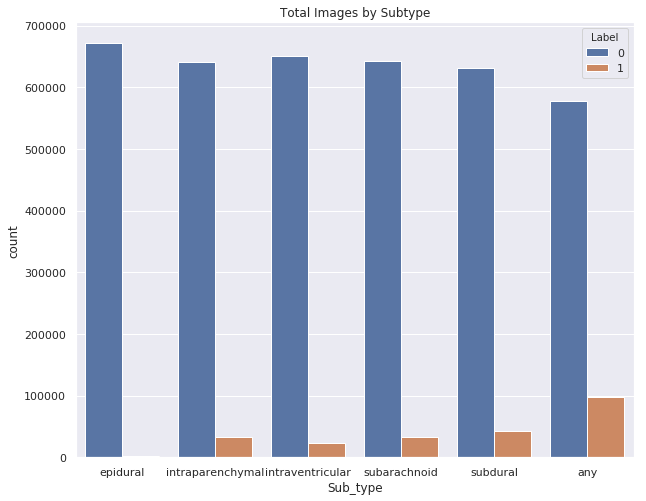

In [57]:
fig=plt.figure(figsize=(10, 8))

sns.countplot(x="Sub_type", hue="Label", data=train)

plt.title("Total Images by Subtype")

In [58]:
def window_image(img, window_center,window_width, intercept, slope):

    img = (img*slope +intercept)
    img_min = window_center - window_width//2
    img_max = window_center + window_width//2
    img[img<img_min] = img_min
    img[img>img_max] = img_max
    return img 
    

def get_first_of_dicom_field_as_int(x):
    #get x[0] as in int is x is a 'pydicom.multival.MultiValue', otherwise get int(x)
    if type(x) == pydicom.multival.MultiValue:
        return int(x[0])
    else:
        return int(x)

def get_windowing(data):
    dicom_fields = [data[('0028','1050')].value, #window center
                    data[('0028','1051')].value, #window width
                    data[('0028','1052')].value, #intercept
                    data[('0028','1053')].value] #slope
    return [get_first_of_dicom_field_as_int(x) for x in dicom_fields]

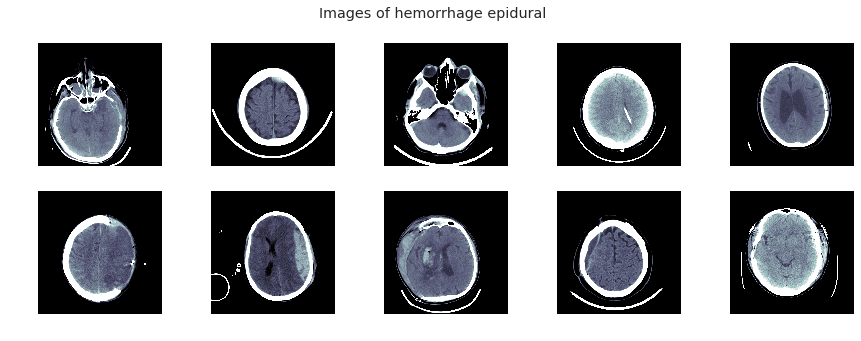

In [59]:
train_images_dir

def view_images(images, title = '', aug = None):
    width = 5
    height = 2
    fig, axs = plt.subplots(height, width, figsize=(15,5))
    
    for im in range(0, height * width):
        ''''
        image = pydicom.read_file(os.path.join(train_images_dir,'ID_'+images[im]+ '.dcm')).pixel_array
        i = im // width
        j = im % width
        axs[i,j].imshow(image, cmap=plt.cm.bone) 
        axs[i,j].axis('off')'''''
        
        data = pydicom.read_file(os.path.join(train_images_dir,'ID_'+images[im]+ '.dcm'))
        image = data.pixel_array
        window_center , window_width, intercept, slope = get_windowing(data)
        image_windowed = window_image(image, window_center, window_width, intercept, slope)


        i = im // width
        j = im % width
        axs[i,j].imshow(image_windowed, cmap=plt.cm.bone) 
        axs[i,j].axis('off')
        
        
    plt.suptitle(title)
    plt.show()

view_images(train[(train['Sub_type'] == 'epidural') & (train['Label'] == 1)][:10].PatientID.values, title = 'Images of hemorrhage epidural')

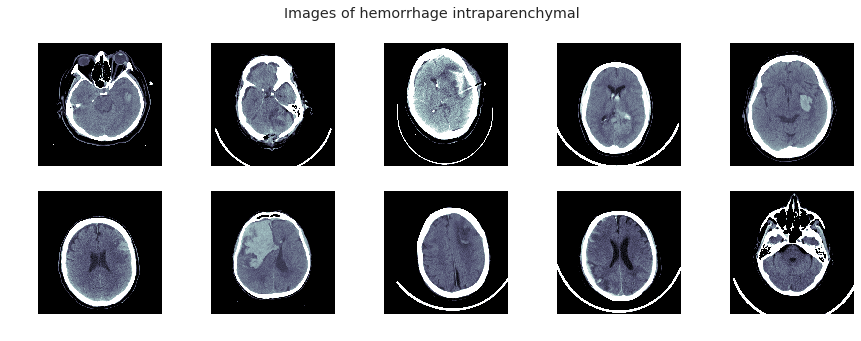

In [60]:
#Visualization of hemorrhage intraparenchymal

view_images(train[(train['Sub_type'] == 'intraparenchymal') & (train['Label'] == 1)][:20].PatientID.values, title = 'Images of hemorrhage intraparenchymal')

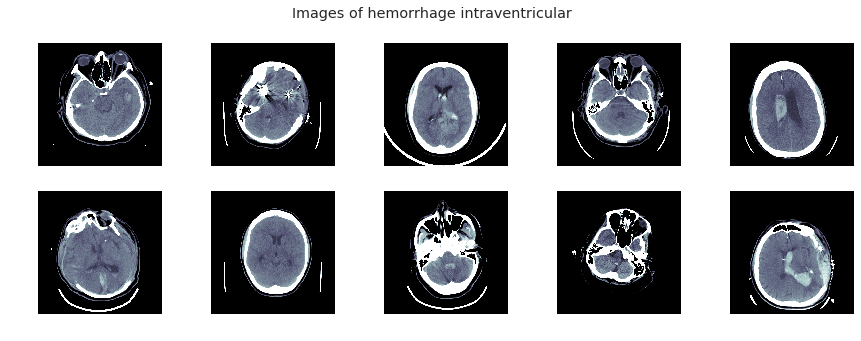

In [61]:
#Visualization of hemorrhage intraventricular

view_images(train[(train['Sub_type'] == 'intraventricular') & (train['Label'] == 1)][:20].PatientID.values, title = 'Images of hemorrhage intraventricular')

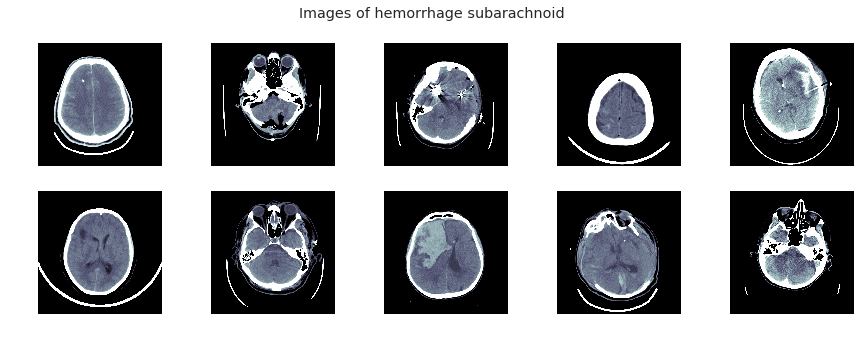

In [62]:
#Visualization of hemorrhage subarachnoid

view_images(train[(train['Sub_type'] == 'subarachnoid') & (train['Label'] == 1)][:20].PatientID.values, title = 'Images of hemorrhage subarachnoid')

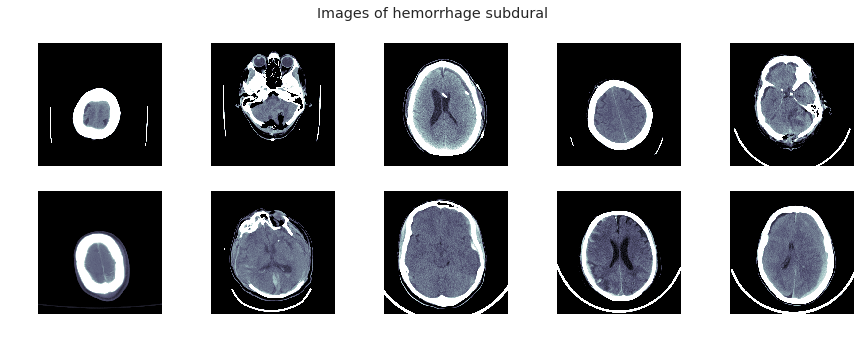

In [63]:
#Visualization of hemorrhage subdural

view_images(train[(train['Sub_type'] == 'subdural') & (train['Label'] == 1)][:20].PatientID.values, title = 'Images of hemorrhage subdural')